### Testing the Environment

In [3]:
# Testing the environment

import cv2
import numpy as np
import tensorflow as tf

print("OpenCV version", cv2.__version__)

print("Numpy version", np.__version__)

print("Tensorflow version", tf.__version__)


OpenCV version 3.1.0
Numpy version 1.13.1
Tensorflow version 1.3.0


### Rotating Camera , No Translation Demo

In [4]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

In [24]:
import numpy as np
import cv2


class Stitcher:
    def __init__(self):
        pass
    
    def detectAndDescribe(self, image):
        # converting the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        print(image.shape)
        
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        #converting the features to numpy array
        kps = np.float32([kp.pt for kp in kps])
        
        return (kps, features)
    
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThres):
        
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        
        matches = []
        
        # looping over the raw matches
        for m in rawMatches:
            # ensure that the distance is within a certain ratio from one-another
            # (Lowe's ration test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))
                
        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct 2 sets from each of the images compared
            ptsA = np.float32([kpsA[i] for (_,i) in matches])
            ptsB = np.float32([kpsB[i] for (_,i) in matches])
            
            #comparing the homography between 2 sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
            
            return (matches, H, status)
        
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
            # initialize the output visualization image
            (hA, wA) = imageA.shape[:2]
            (hB, wB) = imageB.shape[:2]
            vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
            vis[0:hA, 0:wA] = imageA
            vis[0:hB, wA:] = imageB

            # loop over the matches
            for ((trainIdx, queryIdx), s) in zip(matches, status):
                # only process the match if the keypoint was successfully
                # matched
                if s == 1:
                    # draw the match
                    ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                    ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                    cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

            # return the visualization        
            return vis
        
    def stitch(self,images, ratio=0.75, reprojThres=4.0, showMatches=False):
        #unpack the images and detect the keypoints and extract the local invariant descriptors
        
        (imageA, imageB)  = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        # match the features between 2 images
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThres)
        
        if M is None:
            return None
        
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H, imageA.shape[1] + imageB.shape[1], imageA.shape[0])
        
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,status)
            
            return (result, vis)
        
        return result
        
        
        
        

In [27]:
import os
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

%matplotlib inline


IMAGE_1 = os.path.join("..","images","Panorama","bryce_left_01.png")
IMAGE_2 = os.path.join("..","images","Panorama","bryce_right_01.png")

imageA = cv2.imread(IMAGE_1)
imageA = resize(imageA,width=400)

imageB = cv2.imread(IMAGE_2)
imageB = resize(imageB,width=400)

stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

plt.figure("",(10,10))
plt.imshow(imageA)
plt.show()

plt.figure("",(10,10))
plt.imshow(imageB)
plt.show()

#plt.imshow(result)
#plt.show()







(300, 400)
(300, 400)


IndexError: index 971 is out of bounds for axis 0 with size 970

In [45]:
# import the necessary packages
import numpy as np
import cv2

class Stitcher:
	def __init__(self):
		# determine if we are using OpenCV v3.X
		self.isv3 = True

	def stitch(self, images, ratio=0.75, reprojThresh=4.0,
		showMatches=False):
		# unpack the images, then detect keypoints and extract
		# local invariant descriptors from them
		(imageB, imageA) = images
		(kpsA, featuresA) = self.detectAndDescribe(imageA)
		(kpsB, featuresB) = self.detectAndDescribe(imageB)

		# match features between the two images
		M = self.matchKeypoints(kpsA, kpsB,
			featuresA, featuresB, ratio, reprojThresh)

		# if the match is None, then there aren't enough matched
		# keypoints to create a panorama
		if M is None:
			return None

		# otherwise, apply a perspective warp to stitch the images
		# together
		(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], 2*imageB.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
		# check to see if the keypoint matches should be visualized
		if showMatches:
			vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
				status)

			# return a tuple of the stitched image and the
			# visualization
			return (result, vis)

		# return the stitched image
		return result

	def detectAndDescribe(self, image):
		# convert the image to grayscale
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

		# check to see if we are using OpenCV 3.X
		if self.isv3:
			# detect and extract features from the image
			descriptor = cv2.xfeatures2d.SIFT_create()
			(kps, features) = descriptor.detectAndCompute(image, None)

		# otherwise, we are using OpenCV 2.4.X
		else:
			# detect keypoints in the image
			detector = cv2.FeatureDetector_create("SIFT")
			kps = detector.detect(gray)

			# extract features from the image
			extractor = cv2.DescriptorExtractor_create("SIFT")
			(kps, features) = extractor.compute(gray, kps)

		# convert the keypoints from KeyPoint objects to NumPy
		# arrays
		kps = np.float32([kp.pt for kp in kps])

		# return a tuple of keypoints and features
		return (kps, features)

	def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
		ratio, reprojThresh):
		# compute the raw matches and initialize the list of actual
		# matches
		matcher = cv2.DescriptorMatcher_create("BruteForce")
		rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
		matches = []

		# loop over the raw matches
		for m in rawMatches:
			# ensure the distance is within a certain ratio of each
			# other (i.e. Lowe's ratio test)
			if len(m) == 2 and m[0].distance < m[1].distance * ratio:
				matches.append((m[0].trainIdx, m[0].queryIdx))

		# computing a homography requires at least 4 matches
		if len(matches) > 4:
			# construct the two sets of points
			ptsA = np.float32([kpsA[i] for (_, i) in matches])
			ptsB = np.float32([kpsB[i] for (i, _) in matches])

			# compute the homography between the two sets of points
			(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)

			# return the matches along with the homograpy matrix
			# and status of each matched point
			return (matches, H, status)

		# otherwise, no homograpy could be computed
		return None

	def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
		# initialize the output visualization image
		(hA, wA) = imageA.shape[:2]
		(hB, wB) = imageB.shape[:2]
		vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
		vis[0:hA, 0:wA] = imageA
		vis[0:hB, wA:] = imageB

		# loop over the matches
		for ((trainIdx, queryIdx), s) in zip(matches, status):
			# only process the match if the keypoint was successfully
			# matched
			if s == 1:
				# draw the match
				ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
				ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
				cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

		# return the visualization
		return vis

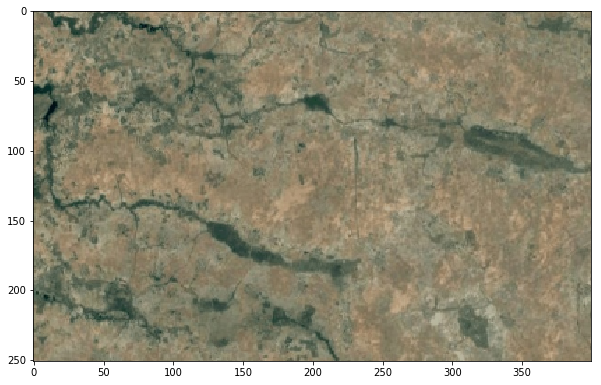

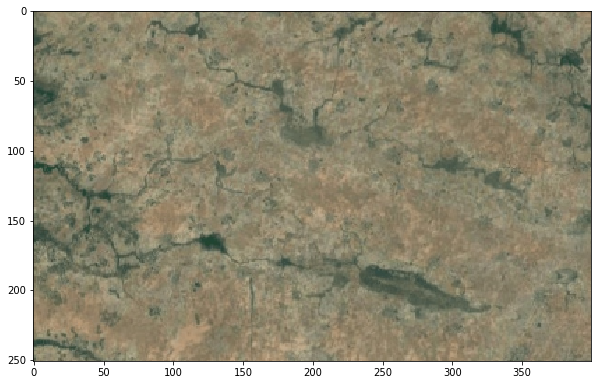

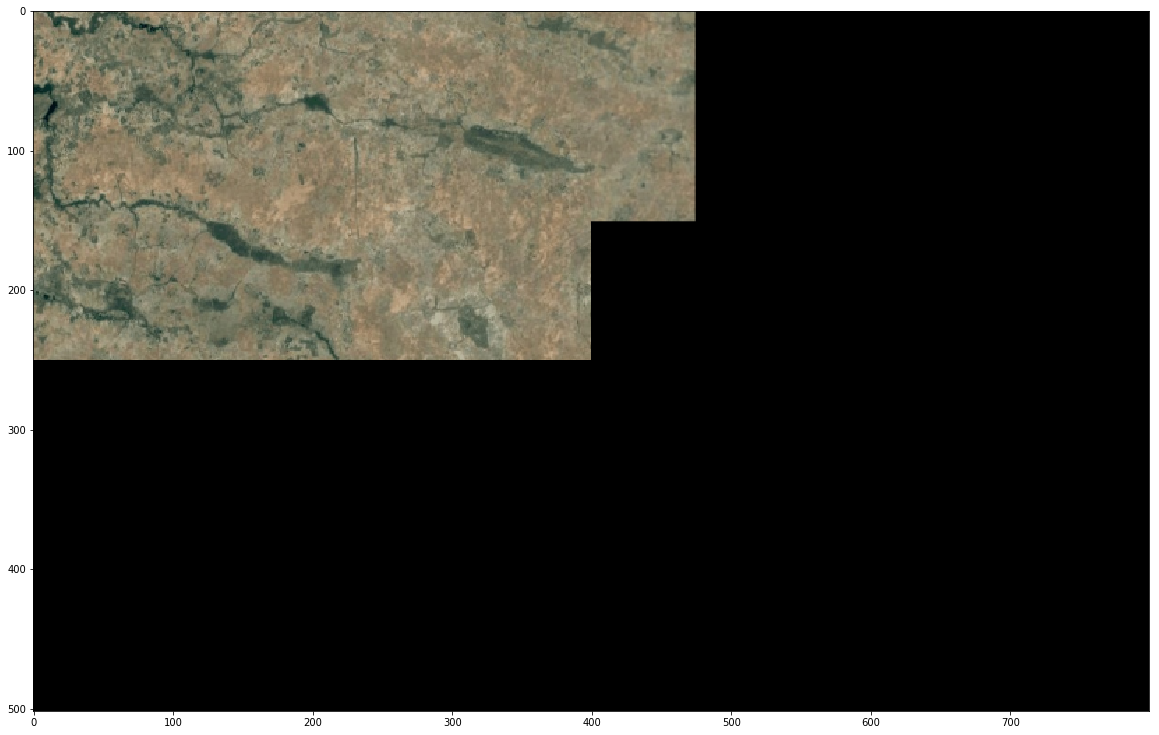

In [46]:
import os
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

%matplotlib inline


#IMAGE_1 = os.path.join("..","images","Panorama","bryce_left_01.png")
#IMAGE_2 = os.path.join("..","images","Panorama","bryce_right_01.png")

IMAGE_1 = os.path.join("..","images","Panorama","map1.jpg")
IMAGE_2 = os.path.join("..","images","Panorama","map2.jpg")
IMAGE_3 = os.path.join("..","images","Panorama","map3.jpg")


imageA = cv2.imread(IMAGE_1)
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
imageA = resize(imageA,width=400)
imageA = imageA[:imageA.shape[0]-15,:,:]

imageB = cv2.imread(IMAGE_2)
imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)
imageB = resize(imageB,width=400)
imageB = imageB[:imageB.shape[0]-15,:,:]

#imageC = cv2.imread(IMAGE_3)
#imageC = cv2.cvtColor(imageC, cv2.COLOR_BGR2RGB)
#imageC = resize(imageC,width=400)
#imageC = imageC[:imageC.shape[0]-15,:,:]

stitcher = Stitcher()

(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)


#(result, vis) = stitcher.stitch([result, imageC], showMatches=True)

#b,g,r = cv2.split(result)
#result = cv2.merge((r,g,b))

plt.figure("",(10,10))
plt.imshow(imageA)
plt.show()

plt.figure("",(10,10))
plt.imshow(imageB)
plt.show()

#plt.figure("",(10,10))
#plt.imshow(imageC)
#plt.show()

plt.figure("",(20,20))
plt.imshow(result)
plt.show()





